Project setup

In [1]:
import os

base = r"C:\Users\rithi\Downloads\autoencoder"

folders = [
    "data/raw_images",
    "data/train",
    "data/val",
    "data/test",
    "models",
    "outputs"
]

for f in folders:
    os.makedirs(os.path.join(base, f), exist_ok=True)

print("✅ Folder structure ready!")


✅ Folder structure ready!


In [2]:
import os, random, shutil

base = r"C:\Users\rithi\Downloads\autoencoder\data"
raw_dir = os.path.join(base, "raw_images")
train_dir = os.path.join(base, "train")
val_dir = os.path.join(base, "val")
test_dir = os.path.join(base, "test")

# Clean old splits (optional)
for folder in [train_dir, val_dir, test_dir]:
    if os.path.exists(folder):
        shutil.rmtree(folder)
    os.makedirs(folder, exist_ok=True)

# List all image files
image_files = [f for f in os.listdir(raw_dir) if f.lower().endswith(('.jpg','.jpeg','.png','.bmp','.webp'))]
random.shuffle(image_files)

# Split ratios
train_ratio, val_ratio, test_ratio = 0.8, 0.1, 0.1
n = len(image_files)
train_split = int(n * train_ratio)
val_split = int(n * (train_ratio + val_ratio))

train_files = image_files[:train_split]
val_files = image_files[train_split:val_split]
test_files = image_files[val_split:]

def copy_files(file_list, dest_folder):
    for f in file_list:
        shutil.copy(os.path.join(raw_dir, f), os.path.join(dest_folder, f))

copy_files(train_files, train_dir)
copy_files(val_files, val_dir)
copy_files(test_files, test_dir)

print(f"✅ Split completed!")
print(f"Train: {len(train_files)} images")
print(f"Val: {len(val_files)} images")
print(f"Test: {len(test_files)} images")


✅ Split completed!
Train: 2491 images
Val: 311 images
Test: 312 images


In [1]:
# Cell 1: imports + paths + device
import os
import glob
import random
from pathlib import Path
from tqdm.notebook import tqdm

import numpy as np
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.utils as vutils

from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim
import matplotlib.pyplot as plt

# Paths (update if different)
BASE = r"C:\Users\rithi\Downloads\autoencoder"
RAW_DIR = os.path.join(BASE, "data", "raw_images")
TRAIN_DIR = os.path.join(BASE, "data", "train")
VAL_DIR   = os.path.join(BASE, "data", "val")
TEST_DIR  = os.path.join(BASE, "data", "test")
MODELS_DIR = os.path.join(BASE, "models")
OUT_DIR = os.path.join(BASE, "outputs")

os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)

# device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)


Device: cpu


In [2]:
# Cell 2: dataset, transforms, dataloaders
from torchvision.transforms.functional import InterpolationMode

IMG_SIZE = 256        # change to 512 if you have lots of GPU memory
BATCH_SIZE = 16
NUM_WORKERS = 4 if torch.cuda.is_available() else 0

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE), interpolation=InterpolationMode.BICUBIC),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.1),
    transforms.ToTensor(),                # returns float in [0,1]
])

eval_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE), interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor(),
])

class ImageFolderDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.paths = sorted([p for p in glob.glob(os.path.join(folder, "*")) if p.lower().endswith(('.jpg','.jpeg','.png','.bmp','.webp'))])
        self.transform = transform
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, idx):
        p = self.paths[idx]
        img = Image.open(p).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, os.path.basename(p)

train_ds = ImageFolderDataset(TRAIN_DIR, transform=train_transform)
val_ds   = ImageFolderDataset(VAL_DIR, transform=eval_transform)
test_ds  = ImageFolderDataset(TEST_DIR, transform=eval_transform)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_dl   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_dl  = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print("Sizes -> train:", len(train_ds), "val:", len(val_ds), "test:", len(test_ds))


Sizes -> train: 2491 val: 311 test: 312


In [5]:
# Cell 4: training loop
import torch.optim as optim

EPOCHS = 40
LR = 1e-4
PATIENCE = 6   # early-stopping patience on val loss

optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.MSELoss()

best_val_loss = float("inf")
patience_cnt = 0

for epoch in range(1, EPOCHS+1):
    model.train()
    running_loss = 0.0
    for imgs, _ in tqdm(train_dl, desc=f"Train Epoch {epoch}/{EPOCHS}"):
        imgs = imgs.to(DEVICE)
        recon = model(imgs)
        loss = criterion(recon, imgs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
    train_loss = running_loss / len(train_ds)

    # validation
    model.eval()
    val_running = 0.0
    with torch.no_grad():
        for imgs, _ in val_dl:
            imgs = imgs.to(DEVICE)
            recon = model(imgs) 
            val_running += criterion(recon, imgs).item() * imgs.size(0)
    val_loss = val_running / len(val_ds)

    print(f"Epoch {epoch}: train_loss={train_loss:.6f}, val_loss={val_loss:.6f}")

    # Checkpoint
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), os.path.join(MODELS_DIR, "best_autoencoder.pth"))
        print("  Saved best model.")
        patience_cnt = 0
    else:
        patience_cnt += 1
        if patience_cnt >= PATIENCE:
            print("Early stopping triggered.")
            break

# load best
model.load_state_dict(torch.load(os.path.join(MODELS_DIR, "best_autoencoder.pth"), map_location=DEVICE))
print("Training finished. Best val loss:", best_val_loss)


Train Epoch 1/40:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 1: train_loss=0.045445, val_loss=0.016694
  Saved best model.


Train Epoch 2/40:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 2: train_loss=0.015448, val_loss=0.012709
  Saved best model.


Train Epoch 3/40:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 3: train_loss=0.012501, val_loss=0.010840
  Saved best model.


Train Epoch 4/40:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 4: train_loss=0.010951, val_loss=0.009917
  Saved best model.


Train Epoch 5/40:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 5: train_loss=0.009771, val_loss=0.008952
  Saved best model.


Train Epoch 6/40:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 6: train_loss=0.009028, val_loss=0.008097
  Saved best model.


Train Epoch 7/40:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 7: train_loss=0.008293, val_loss=0.007571
  Saved best model.


Train Epoch 8/40:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 8: train_loss=0.007856, val_loss=0.007354
  Saved best model.


Train Epoch 9/40:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 9: train_loss=0.007405, val_loss=0.006884
  Saved best model.


Train Epoch 10/40:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 10: train_loss=0.007146, val_loss=0.006782
  Saved best model.


Train Epoch 11/40:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 11: train_loss=0.006785, val_loss=0.006241
  Saved best model.


Train Epoch 12/40:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 12: train_loss=0.006559, val_loss=0.006092
  Saved best model.


Train Epoch 13/40:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 13: train_loss=0.006402, val_loss=0.005832
  Saved best model.


Train Epoch 14/40:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 14: train_loss=0.006222, val_loss=0.005680
  Saved best model.


Train Epoch 15/40:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 15: train_loss=0.005866, val_loss=0.005509
  Saved best model.


Train Epoch 16/40:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 16: train_loss=0.005750, val_loss=0.005292
  Saved best model.


Train Epoch 17/40:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 17: train_loss=0.005597, val_loss=0.005268
  Saved best model.


Train Epoch 18/40:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 18: train_loss=0.005499, val_loss=0.005046
  Saved best model.


Train Epoch 19/40:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 19: train_loss=0.005267, val_loss=0.005046


Train Epoch 20/40:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 20: train_loss=0.005163, val_loss=0.004758
  Saved best model.


Train Epoch 21/40:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 21: train_loss=0.005022, val_loss=0.004664
  Saved best model.


Train Epoch 22/40:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 22: train_loss=0.004952, val_loss=0.004585
  Saved best model.


Train Epoch 23/40:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 23: train_loss=0.004831, val_loss=0.004683


Train Epoch 24/40:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 24: train_loss=0.004798, val_loss=0.004425
  Saved best model.


Train Epoch 25/40:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 25: train_loss=0.004670, val_loss=0.004550


Train Epoch 26/40:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 26: train_loss=0.004571, val_loss=0.004309
  Saved best model.


Train Epoch 27/40:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 27: train_loss=0.004527, val_loss=0.004373


Train Epoch 28/40:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 28: train_loss=0.004512, val_loss=0.004342


Train Epoch 29/40:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 29: train_loss=0.004348, val_loss=0.004072
  Saved best model.


Train Epoch 30/40:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 30: train_loss=0.004295, val_loss=0.004418


Train Epoch 31/40:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 31: train_loss=0.004153, val_loss=0.003970
  Saved best model.


Train Epoch 32/40:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 32: train_loss=0.004228, val_loss=0.003947
  Saved best model.


Train Epoch 33/40:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 33: train_loss=0.004093, val_loss=0.003866
  Saved best model.


Train Epoch 34/40:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 34: train_loss=0.004048, val_loss=0.003772
  Saved best model.


Train Epoch 35/40:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 35: train_loss=0.003995, val_loss=0.003716
  Saved best model.


Train Epoch 36/40:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 36: train_loss=0.003866, val_loss=0.003829


Train Epoch 37/40:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 37: train_loss=0.003889, val_loss=0.003601
  Saved best model.


Train Epoch 38/40:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 38: train_loss=0.003805, val_loss=0.003657


Train Epoch 39/40:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 39: train_loss=0.003735, val_loss=0.003989


Train Epoch 40/40:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 40: train_loss=0.003699, val_loss=0.003634
Training finished. Best val loss: 0.0036010904038486662


Testing:   1%|▉                                                                        | 4/312 [00:00<00:57,  5.32it/s]


✅ Avg PSNR: 26.02 dB
✅ Avg SSIM: 0.7519


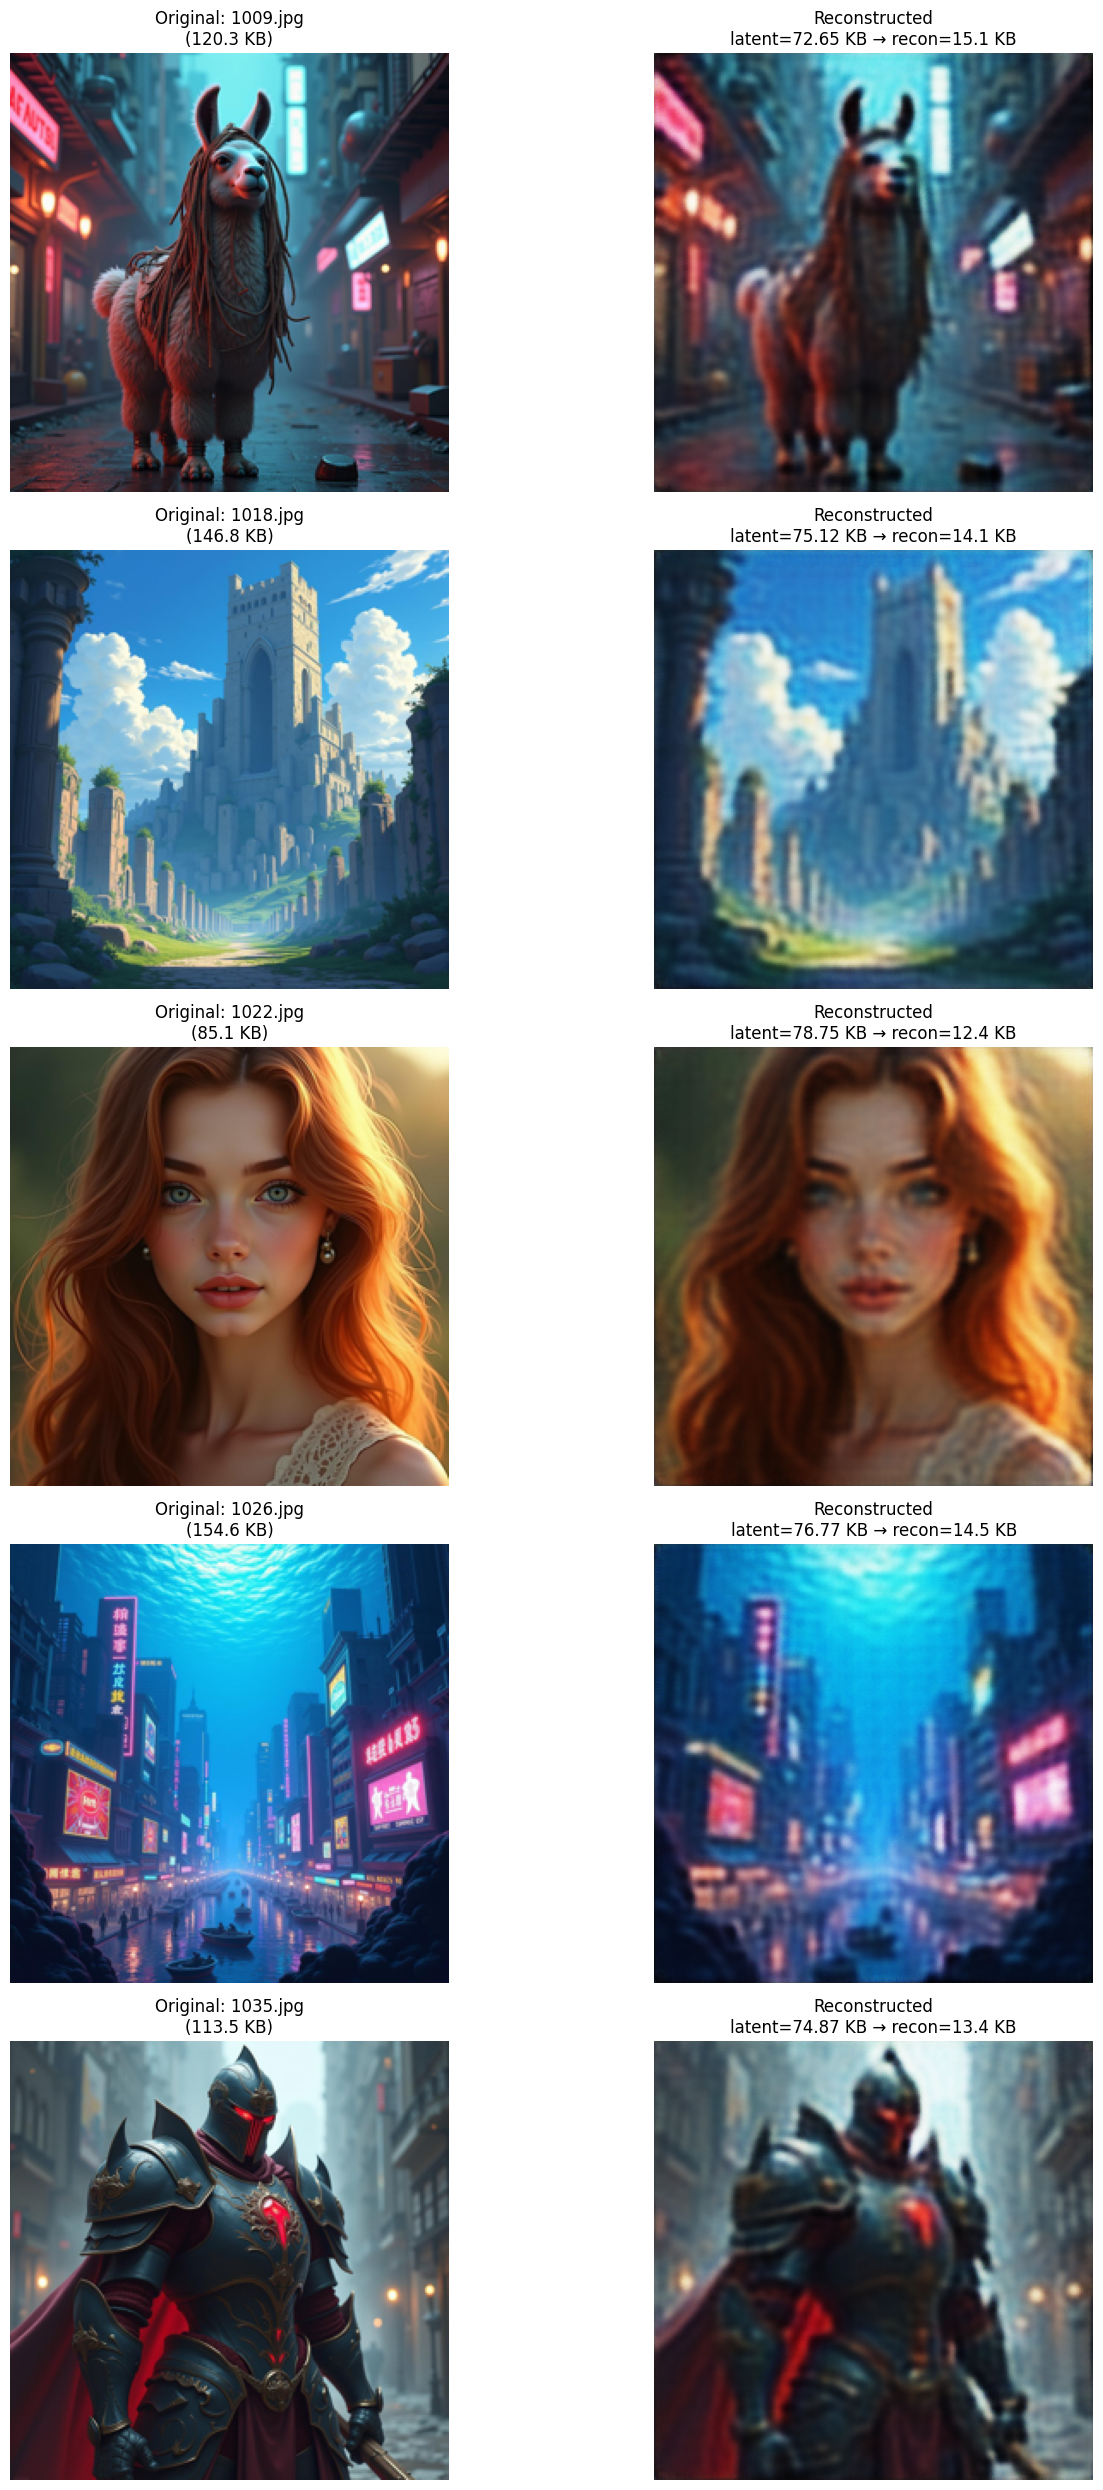


📦 Avg on-disk compression ratio: 1.6× smaller


In [14]:
# ✅ Cell 5: Evaluate model with actual .npz compression size
import os, io, numpy as np, torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim

model.eval()
psnrs, ssims = [], []

def tensor_to_numpy(img_tensor):
    arr = img_tensor.detach().cpu().numpy().transpose(1,2,0)
    arr = np.clip(arr, 0, 1)
    return (arr * 255).astype(np.uint8)

def save_latent_as_npz(latent, name):
    """Save latent tensor as compressed .npz and return its size (KB)"""
    z = latent.detach().cpu().numpy().astype(np.float16)
    max_abs = np.abs(z).max()
    z_norm = z / (max_abs + 1e-8)
    z_q = np.round(z_norm * 127).astype(np.int8)
    path = os.path.join(OUT_DIR, f"{os.path.splitext(name)[0]}.npz")
    np.savez_compressed(path, z=z_q, max_abs=max_abs)
    return os.path.getsize(path) / 1024.0, path

# ------------------------
# Run evaluation
# ------------------------
sample_show = []
os.makedirs(OUT_DIR, exist_ok=True)

with torch.no_grad():
    for imgs, names in tqdm(test_dl, desc="Testing"):
        imgs = imgs.to(DEVICE)
        latents = model.encoder(imgs)
        recons = model(imgs)

        for i in range(imgs.size(0)):
            orig_np = tensor_to_numpy(imgs[i])
            recon_np = tensor_to_numpy(recons[i])

            # Compute metrics
            psnr = compare_psnr(orig_np, recon_np, data_range=255)
            ssim = compare_ssim(orig_np, recon_np, channel_axis=-1, data_range=255)
            psnrs.append(psnr)
            ssims.append(ssim)

            # File size (real-world)
            name = names[i] if isinstance(names[i], str) else str(i)
            orig_path = os.path.join(TEST_DIR, name)
            orig_kb = os.path.getsize(orig_path)/1024 if os.path.exists(orig_path) else 0
            latent_kb, npz_path = save_latent_as_npz(latents[i], name)

            # Save reconstructed as temporary JPG to check realistic output size
            from PIL import Image
            recon_pil = Image.fromarray(recon_np)
            recon_buf = io.BytesIO()
            recon_pil.save(recon_buf, format='JPEG', quality=90)
            recon_kb = len(recon_buf.getvalue()) / 1024.0

            if len(sample_show) < 5:
                sample_show.append((orig_np, recon_np, name, orig_kb, latent_kb, recon_kb))
        if len(sample_show) >= 5:
            break

# ------------------------
# Summary
# ------------------------
print(f"✅ Avg PSNR: {np.mean(psnrs):.2f} dB")
print(f"✅ Avg SSIM: {np.mean(ssims):.4f}")

# ------------------------
# Visualization
# ------------------------
n = len(sample_show)
plt.figure(figsize=(15, 5 * n))

for i, (orig, recon, name, orig_kb, latent_kb, recon_kb) in enumerate(sample_show):
    plt.subplot(n, 2, 2*i+1)
    plt.imshow(orig)
    plt.title(f"Original: {name}\n({orig_kb:.1f} KB)")
    plt.axis("off")

    plt.subplot(n, 2, 2*i+2)
    plt.imshow(recon)
    plt.title(f"Reconstructed\nlatent={latent_kb:.2f} KB → recon={recon_kb:.1f} KB")
    plt.axis("off")

plt.tight_layout()
plt.show()

ratios = [orig_kb / latent_kb for _,_,_,orig_kb,latent_kb,_ in sample_show if latent_kb>0]
print(f"\n📦 Avg on-disk compression ratio: {np.mean(ratios):.1f}× smaller")


In [10]:
# Cell 6: encode a single image to quantized latent and save, get file sizes
import gzip
import io

model.eval()
encoder = model.encoder  # feature extractor

def compress_and_save(img_path, out_prefix, quant_scale=127.0):
    """
    - loads img_path, preprocesses, gets latent z
    - quantizes z: z_q = round(z * quant_scale).astype(np.int8)
    - saves compressed npz: np.savez_compressed(out_prefix + ".npz", z=z_q)
    - returns sizes: orig_kb, latent_kb
    """
    img = Image.open(img_path).convert("RGB")
    img = eval_transform(img).unsqueeze(0).to(DEVICE)  # 1,3,H,W
    with torch.no_grad():
        z = encoder(img)                     # shape (1,C,H',W')
        z_cpu = z.detach().cpu().numpy()[0]  # (C,H',W')

    # normalize to -1..1 then scale -> here we assume z>=0 due to ReLU so scale accordingly
    # find max absolute for safety
    max_abs = np.max(np.abs(z_cpu)) if np.max(np.abs(z_cpu))>0 else 1.0
    z_norm = z_cpu / max_abs
    z_q = np.round(z_norm * quant_scale).astype(np.int16)  # int16 to be safe

    save_path = os.path.join(OUT_DIR, out_prefix + ".npz")
    np.savez_compressed(save_path, z=z_q, max_abs=max_abs)
    latent_kb = os.path.getsize(save_path) / 1024.0
    orig_kb = os.path.getsize(img_path) / 1024.0
    return orig_kb, latent_kb, save_path

# test on 5 images from test folder
test_images = sorted([p for p in glob.glob(os.path.join(TEST_DIR, "*")) if p.lower().endswith(('.jpg','.png'))])[:5]
for p in test_images:
    orig_kb, latent_kb, path_saved = compress_and_save(p, out_prefix=Path(p).stem)
    print(f"{Path(p).name}: orig={orig_kb:.1f} KB -> latent(npz)={latent_kb:.1f} KB saved at {path_saved}")


1009.jpg: orig=120.3 KB -> latent(npz)=89.8 KB saved at C:\Users\rithi\Downloads\autoencoder\outputs\1009.npz
1018.jpg: orig=146.8 KB -> latent(npz)=92.3 KB saved at C:\Users\rithi\Downloads\autoencoder\outputs\1018.npz
1022.jpg: orig=85.1 KB -> latent(npz)=96.8 KB saved at C:\Users\rithi\Downloads\autoencoder\outputs\1022.npz
1026.jpg: orig=154.6 KB -> latent(npz)=93.4 KB saved at C:\Users\rithi\Downloads\autoencoder\outputs\1026.npz
1035.jpg: orig=113.5 KB -> latent(npz)=92.4 KB saved at C:\Users\rithi\Downloads\autoencoder\outputs\1035.npz


✅ Loaded model: C:\Users\rithi\Downloads\best_autoencoder (1).pth
✅ Test images: 312 from C:\Users\rithi\Downloads\autoencoder\data\test


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 10/10 [00:56<00:00,  5.62s/it]



📊 --- Test Evaluation ---
🧪 Test Loss (MSE): 0.002658
✅ Mean PSNR: 26.63 dB
✅ Mean SSIM: 0.7905


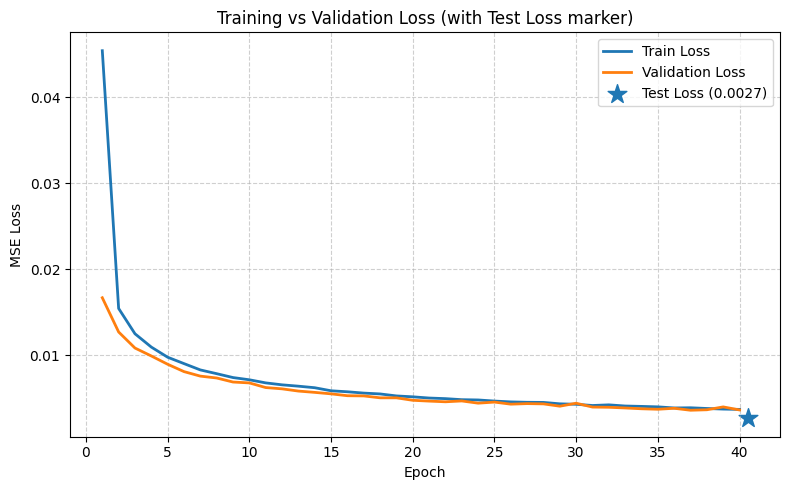

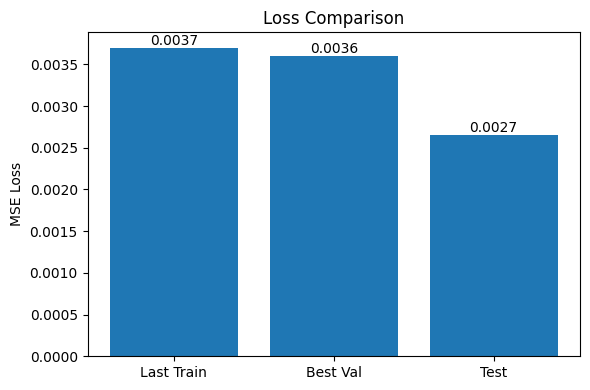

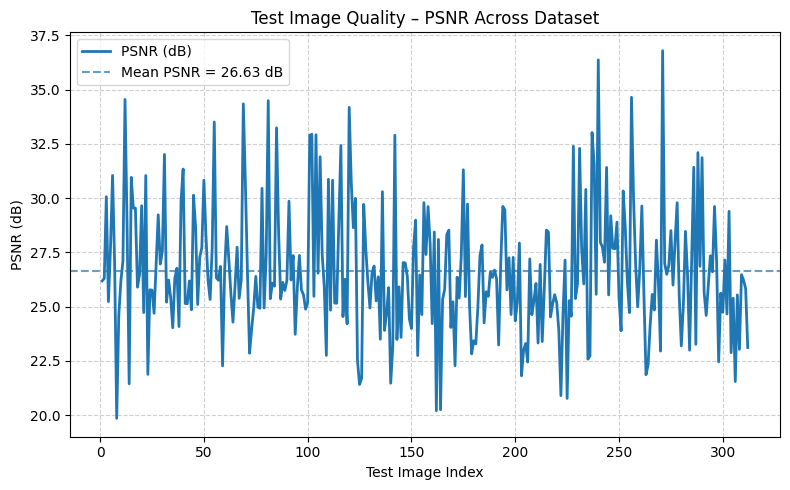

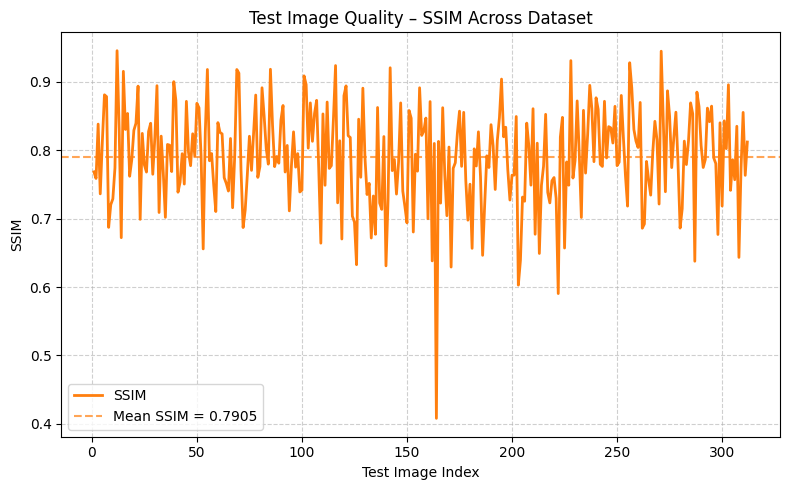

In [2]:
import os, random, numpy as np, torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim

# -------------------------------
# Paths & device
# -------------------------------
MODEL_PATH = r"C:\Users\rithi\Downloads\best_autoencoder (1).pth"
TEST_DIR   = r"C:\Users\rithi\Downloads\autoencoder\data\test"
DEVICE     = "cuda" if torch.cuda.is_available() else "cpu"

# -------------------------------
# Corrected training history (from your logs)
# -------------------------------
train_losses = [
    0.045445, 0.015448, 0.012501, 0.010951, 0.009771,
    0.009028, 0.008293, 0.007856, 0.007405, 0.007146,
    0.006785, 0.006559, 0.006402, 0.006222, 0.005866,
    0.005750, 0.005597, 0.005499, 0.005267, 0.005163,
    0.005022, 0.004952, 0.004831, 0.004798, 0.004670,
    0.004571, 0.004527, 0.004512, 0.004348, 0.004295,
    0.004153, 0.004228, 0.004093, 0.004048, 0.003995,
    0.003866, 0.003889, 0.003805, 0.003735, 0.003699
]

val_losses = [
    0.016694, 0.012709, 0.010840, 0.009917, 0.008952,
    0.008097, 0.007571, 0.007354, 0.006884, 0.006782,
    0.006241, 0.006092, 0.005832, 0.005680, 0.005509,
    0.005292, 0.005268, 0.005046, 0.005046, 0.004758,
    0.004664, 0.004585, 0.004683, 0.004425, 0.004550,
    0.004309, 0.004373, 0.004342, 0.004072, 0.004418,
    0.003970, 0.003947, 0.003866, 0.003772, 0.003716,
    0.003829, 0.003601, 0.003657, 0.003989, 0.003634
]

# -------------------------------
# Model (must match training)
# -------------------------------
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), nn.ReLU(True),
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU(True),
            nn.Conv2d(128, 256, 4, 2, 1), nn.ReLU(True),
            nn.Conv2d(256, 512, 4, 2, 1), nn.ReLU(True),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1), nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1), nn.Sigmoid(),
        )
    def forward(self, x):
        return self.decoder(self.encoder(x))

model = ConvAutoencoder().to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()
print("✅ Loaded model:", MODEL_PATH)

# -------------------------------
# Classless test dataset
# -------------------------------
class SimpleImageFolder(Dataset):
    def __init__(self, folder, transform=None):
        from glob import glob
        self.files = sorted(glob(os.path.join(folder, "*.jpg")) + glob(os.path.join(folder, "*.jpeg")) + glob(os.path.join(folder, "*.png")))
        self.transform = transform
    def __len__(self):
        return len(self.files)
    def __getitem__(self, idx):
        img = Image.open(self.files[idx]).convert("RGB")
        if self.transform: img = self.transform(img)
        return img, 0

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

test_ds = SimpleImageFolder(TEST_DIR, transform)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False)
print(f"✅ Test images: {len(test_ds)} from {TEST_DIR}")

# -------------------------------
# Evaluate on test set (loss + PSNR/SSIM)
# -------------------------------
criterion = nn.MSELoss()
test_running = 0.0
psnr_vals, ssim_vals = [], []

with torch.no_grad():
    for imgs, _ in tqdm(test_dl, desc="Testing"):
        imgs = imgs.to(DEVICE)
        recon = model(imgs)
        test_running += criterion(recon, imgs).item() * imgs.size(0)

        # PSNR/SSIM per-image
        for i in range(imgs.size(0)):
            orig = imgs[i].permute(1, 2, 0).cpu().numpy()
            rec  = recon[i].permute(1, 2, 0).cpu().numpy()
            orig = np.clip(orig, 0, 1); rec = np.clip(rec, 0, 1)
            psnr_vals.append(compare_psnr(orig, rec, data_range=1.0))
            ssim_vals.append(compare_ssim(orig, rec, channel_axis=-1, data_range=1.0))

test_loss = test_running / len(test_ds)
psnr_mean = float(np.mean(psnr_vals)) if psnr_vals else float("nan")
ssim_mean = float(np.mean(ssim_vals)) if ssim_vals else float("nan")

print("\n📊 --- Test Evaluation ---")
print(f"🧪 Test Loss (MSE): {test_loss:.6f}")
print(f"✅ Mean PSNR: {psnr_mean:.2f} dB")
print(f"✅ Mean SSIM: {ssim_mean:.4f}")

# -------------------------------
# Plot 1: Train vs Val loss + Test loss marker
# -------------------------------
epochs = np.arange(1, len(train_losses) + 1)
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, label="Train Loss", linewidth=2)
plt.plot(epochs, val_losses,   label="Validation Loss", linewidth=2)
plt.scatter([len(train_losses) + 0.5], [test_loss], marker='*', s=200, label=f"Test Loss ({test_loss:.4f})")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training vs Validation Loss (with Test Loss marker)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# -------------------------------
# Plot 2: Simple comparison bars (last Train, best Val, Test)
# -------------------------------
last_train = train_losses[-1]
best_val  = min(val_losses)
plt.figure(figsize=(6, 4))
labels = ["Last Train", "Best Val", "Test"]
vals   = [last_train,  best_val,   test_loss]
plt.bar(labels, vals)
plt.ylabel("MSE Loss")
plt.title("Loss Comparison")
for i,v in enumerate(vals):
    plt.text(i, v, f"{v:.4f}", ha='center', va='bottom')
plt.tight_layout()
plt.show()

# -------------------------------
# Plot 3: PSNR and SSIM trends across test set
# -------------------------------
x = np.arange(1, len(psnr_vals) + 1)

# PSNR curve
plt.figure(figsize=(8, 5))
plt.plot(x, psnr_vals, label='PSNR (dB)', color='tab:blue', linewidth=2)
plt.axhline(np.mean(psnr_vals), color='tab:blue', linestyle='--', alpha=0.7, label=f"Mean PSNR = {np.mean(psnr_vals):.2f} dB")
plt.xlabel("Test Image Index")
plt.ylabel("PSNR (dB)")
plt.title("Test Image Quality – PSNR Across Dataset")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# SSIM curve
plt.figure(figsize=(8, 5))
plt.plot(x, ssim_vals, label='SSIM', color='tab:orange', linewidth=2)
plt.axhline(np.mean(ssim_vals), color='tab:orange', linestyle='--', alpha=0.7, label=f"Mean SSIM = {np.mean(ssim_vals):.4f}")
plt.xlabel("Test Image Index")
plt.ylabel("SSIM")
plt.title("Test Image Quality – SSIM Across Dataset")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


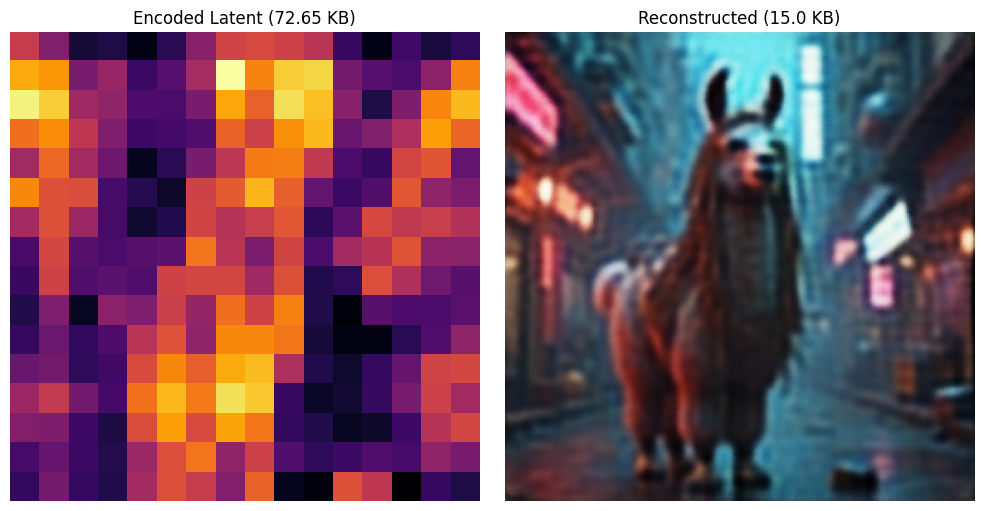

🧾 File: 1009.npz
📦 Encoded latent (.npz): 72.65 KB
🔁 Reconstructed (JPEG est.): 15.0 KB


In [16]:
# ✅ Cell 7: Reconstruct from saved latent .npz, show size info + metrics
import os, glob, io, torch
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim
from PIL import Image
import cv2

def reconstruct_from_npz(npz_path):
    """Load quantized latent and reconstruct via decoder"""
    data = np.load(npz_path)
    z_q = data['z']            # quantized int array
    max_abs = float(data['max_abs'])

    # De-quantize
    z_norm = z_q.astype(np.float32) / 127.0
    z_cpu = z_norm * max_abs
    z_tensor = torch.from_numpy(z_cpu).unsqueeze(0).to(DEVICE).float()

    # Decode to image
    with torch.no_grad():
        recon = model.decoder(z_tensor)
    recon_img = tensor_to_numpy(recon[0])  # uint8 image
    return recon_img, z_q, max_abs

def get_file_size_kb(path):
    return os.path.getsize(path) / 1024.0 if os.path.exists(path) else 0

def save_temp_jpeg_and_size(img_np):
    """Save numpy image to memory as JPEG, return size in KB"""
    buf = io.BytesIO()
    Image.fromarray(img_np).save(buf, format="JPEG", quality=90)
    return len(buf.getvalue()) / 1024.0

# -------------------
# 🔹 Pick first latent file
# -------------------
saved_files = sorted(glob.glob(os.path.join(OUT_DIR, "*.npz")))
if not saved_files:
    print("❌ No .npz files found in outputs/. Run Cell 6 first to create them.")
else:
    npz_path = saved_files[0]
    recon_img, z_q, max_abs = reconstruct_from_npz(npz_path)
    latent_kb = get_file_size_kb(npz_path)

    # Match original
    base_name = os.path.splitext(os.path.basename(npz_path))[0]
    orig_path = os.path.join(TEST_DIR, base_name)
    if os.path.exists(orig_path):
        orig_img = cv2.cvtColor(cv2.imread(orig_path), cv2.COLOR_BGR2RGB)
        orig_kb = get_file_size_kb(orig_path)

        # Resize original to match reconstructed (if needed)
        if orig_img.shape != recon_img.shape:
            orig_img = cv2.resize(orig_img, (recon_img.shape[1], recon_img.shape[0]))

        # Compute metrics
        psnr_val = compare_psnr(orig_img, recon_img, data_range=255)
        ssim_val = compare_ssim(orig_img, recon_img, channel_axis=-1, data_range=255)
    else:
        orig_img, orig_kb, psnr_val, ssim_val = None, 0, None, None

    # Estimate realistic reconstructed file size
    recon_kb = save_temp_jpeg_and_size(recon_img)

    # Compression ratio
    ratio = (orig_kb / latent_kb) if latent_kb > 0 else 0

    # -------------------
    # 🖼 Display
    # -------------------
    plt.figure(figsize=(15, 5))

    if orig_img is not None:
        plt.subplot(1, 3, 1)
        plt.imshow(orig_img)
        plt.title(f"Original ({orig_kb:.1f} KB)")
        plt.axis("off")

    plt.subplot(1, 3, 2)
    heatmap = np.mean(z_q, axis=0) if z_q.ndim == 3 else z_q
    plt.imshow(heatmap, cmap='inferno')
    plt.title(f"Encoded Latent ({latent_kb:.2f} KB)")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(recon_img)
    plt.title(f"Reconstructed ({recon_kb:.1f} KB)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    # -------------------
    # 📊 Summary
    # -------------------
    print(f"🧾 File: {os.path.basename(npz_path)}")
    if orig_kb:
        print(f"🖼 Original size: {orig_kb:.1f} KB")
    print(f"📦 Encoded latent (.npz): {latent_kb:.2f} KB")
    print(f"🔁 Reconstructed (JPEG est.): {recon_kb:.1f} KB")
    if orig_kb:
        print(f"📉 Compression ≈ {ratio:.1f}× smaller than original")
    if psnr_val is not None:
        print(f"✅ PSNR: {psnr_val:.2f} dB | SSIM: {ssim_val:.4f}")


In [10]:
import os, torch, numpy as np, matplotlib.pyplot as plt, cv2
from torch import nn
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim

# -------------------------
# 📁 Adjust paths (fixed)
# -------------------------
MODEL_PATH = r"C:/Users/rithi/Downloads/autoencoder/models/best_autoencoder.pth"
OUT_DIR = r"C:/Users/rithi/Downloads/autoencoder/outputs/reconstructed"  
os.makedirs(OUT_DIR, exist_ok=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# -------------------------
# 🧠 Define architecture (matches your training model)
# -------------------------
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), nn.ReLU(True),
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU(True),
            nn.Conv2d(128, 256, 4, 2, 1), nn.ReLU(True),
            nn.Conv2d(256, 512, 4, 2, 1), nn.ReLU(True),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1), nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1), nn.Sigmoid(),
        )

model = ConvAutoencoder().to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()
print("✅ Model loaded successfully.")

# -------------------------
# 🧾 Helper functions
# -------------------------
def tensor_to_numpy(t):
    arr = t.detach().cpu().permute(1,2,0).numpy()
    arr = np.clip(arr, 0, 1)
    return (arr * 255).astype(np.uint8)

def get_file_size_kb(path):
    return os.path.getsize(path)/1024.0 if os.path.exists(path) else 0.0

# -------------------------
# ⚙️ Encode + Decode function (fixed and robust)
# -------------------------
def process_image(img_path):
    # read original and create resized version for model
    orig_bgr = cv2.imread(img_path)
    if orig_bgr is None:
        raise FileNotFoundError(f"Cannot read image: {img_path}")
    orig_rgb = cv2.cvtColor(orig_bgr, cv2.COLOR_BGR2RGB)

    # resize to model input (256x256)
    img_resized = cv2.resize(orig_rgb, (256, 256))

    # prepare tensor (no torchvision Resize here)
    img_tensor = torch.from_numpy(img_resized.astype(np.float32) / 255.0).permute(2,0,1).unsqueeze(0).to(DEVICE)

    # encode/decode
    with torch.no_grad():
        z = model.encoder(img_tensor)
        recon = model.decoder(z)

    # save latent (.npz) and reconstruction using robust names
    base, ext = os.path.splitext(os.path.basename(img_path))
    latent_path = os.path.join(OUT_DIR, f"{base}.npz")
    recon_path  = os.path.join(OUT_DIR, f"{base}_recon{ext}")

    # quantize and save compressed latent
    z_cpu = z.squeeze(0).cpu().numpy()
    max_abs = float(np.max(np.abs(z_cpu)) if np.max(np.abs(z_cpu))>0 else 1.0)
    z_norm = z_cpu / max_abs
    z_q = np.round(z_norm * 127).astype(np.int8)
    np.savez_compressed(latent_path, z=z_q, max_abs=max_abs)

    # prepare reconstructed image (uint8)
    recon_img = tensor_to_numpy(recon[0])

    # save reconstruction
    from PIL import Image
    img_pil = Image.fromarray(recon_img)
    if ext.lower() == ".png":
        img_pil.save(recon_path, format="PNG")
    else:
        img_pil.save(recon_path, format="JPEG", quality=95)

    # get sizes
    orig_kb   = get_file_size_kb(img_path)
    latent_kb = get_file_size_kb(latent_path)
    recon_kb  = get_file_size_kb(recon_path)

    # convert both tensors to compute MSE loss
    mse_loss_fn = nn.MSELoss()
    loss_val = mse_loss_fn(recon, img_tensor).item()

    # metrics between resized original and reconstruction
    psnr_val = compare_psnr(img_resized, recon_img, data_range=255)
    ssim_val = compare_ssim(img_resized, recon_img, channel_axis=-1, data_range=255)

    # visualize
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1); plt.imshow(img_resized); plt.title(f"Original Resized\n{orig_kb:.1f} KB"); plt.axis('off')
    plt.subplot(1,3,2); plt.imshow(np.mean(z_q, axis=0), cmap='inferno'); plt.title(f"Encoded Latent\n(saved: {latent_kb:.2f} KB)"); plt.axis('off')
    plt.subplot(1,3,3); plt.imshow(recon_img); plt.title(f"Reconstructed\n(saved: {recon_kb:.1f} KB)"); plt.axis('off')
    plt.tight_layout()
    plt.show()

    # summary printout
    ratio = (orig_kb / latent_kb) if latent_kb > 0 else float('inf')
    print(f"\n📁 Image: {os.path.basename(img_path)}")
    print(f"📦 Latent: {latent_path} ({latent_kb:.2f} KB)")
    print(f"🖼️ Reconstructed: {recon_path} ({recon_kb:.1f} KB)")
    print(f"📉 Compression ratio: {ratio:.1f}× (orig → latent)")
    print(f"📊 Metrics →  PSNR: {psnr_val:.2f} dB  |  SSIM: {ssim_val:.4f}  |  Loss (MSE): {loss_val:.6f}")

    return latent_path, recon_path


✅ Model loaded successfully.


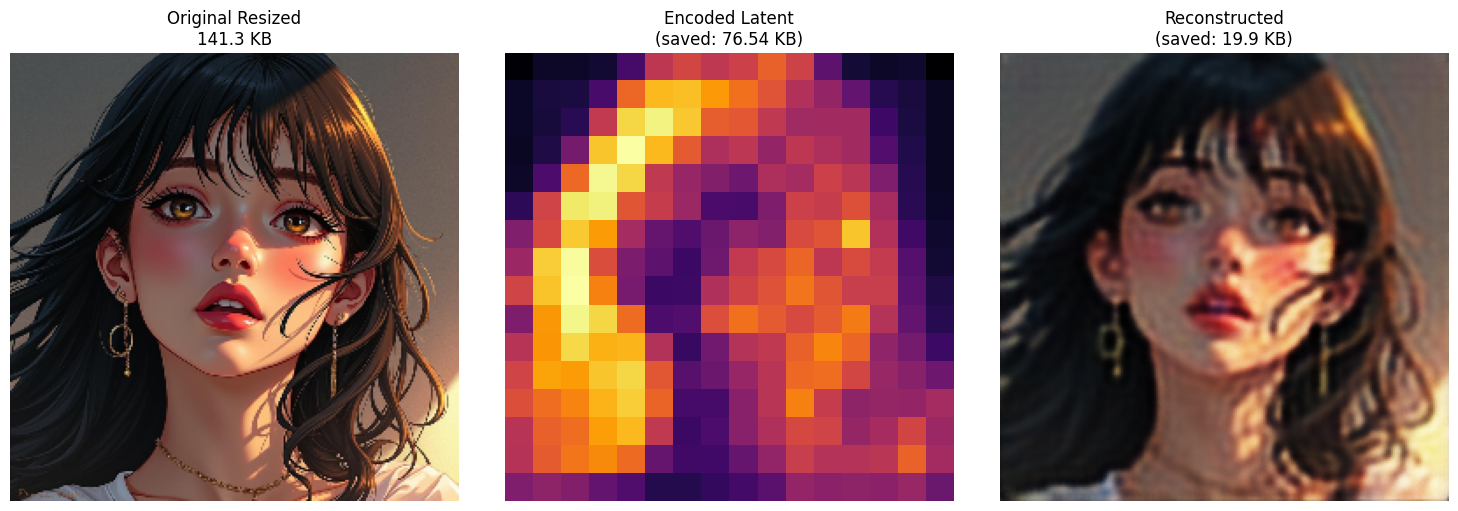


📁 Image: 2194.jpg
📦 Latent: C:/Users/rithi/Downloads/autoencoder/outputs/reconstructed\2194.npz (76.54 KB)
🖼️ Reconstructed: C:/Users/rithi/Downloads/autoencoder/outputs/reconstructed\2194_recon.jpg (19.9 KB)
📉 Compression ratio: 1.8× (orig → latent)
📊 Metrics →  PSNR: 22.89 dB  |  SSIM: 0.6680  |  Loss (MSE): 0.005126


In [11]:

# -------------------------
# 🖼️ Manual image entry (bottom of cell)
# -------------------------
img_path = r"C:\Users\rithi\Downloads\autoencoder\data\raw_images\2194.jpg"  # update as needed
if os.path.exists(img_path):
    latent_path, recon_path = process_image(img_path)
else:
    print("❌ Invalid image path:", img_path)


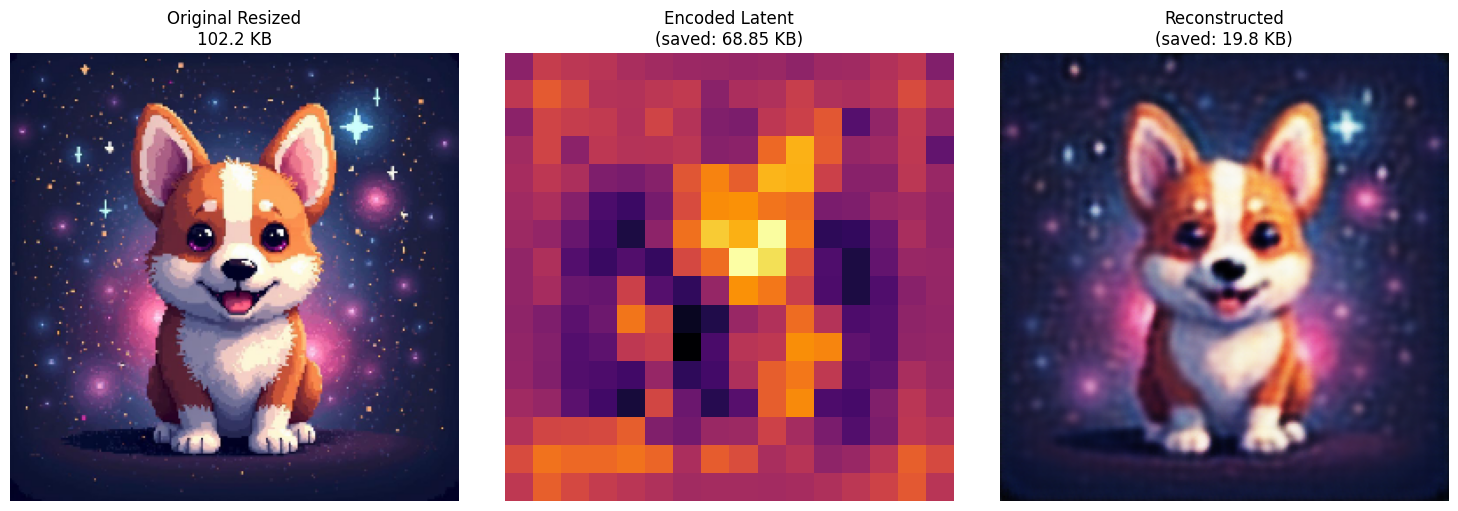


📁 Image: 56.jpg
📦 Latent: C:/Users/rithi/Downloads/autoencoder/outputs/reconstructed\56.npz (68.85 KB)
🖼️ Reconstructed: C:/Users/rithi/Downloads/autoencoder/outputs/reconstructed\56_recon.jpg (19.8 KB)
📉 Compression ratio: 1.5× (orig → latent)
📊 Metrics →  PSNR: 23.87 dB  |  SSIM: 0.6946  |  Loss (MSE): 0.004086


In [7]:
img_path = r"C:\Users\rithi\Downloads\autoencoder\data\val\56.jpg" 
if os.path.exists(img_path):
    latent_path, recon_path = process_image(img_path)
else:
    print("❌ Invalid image path:", img_path)


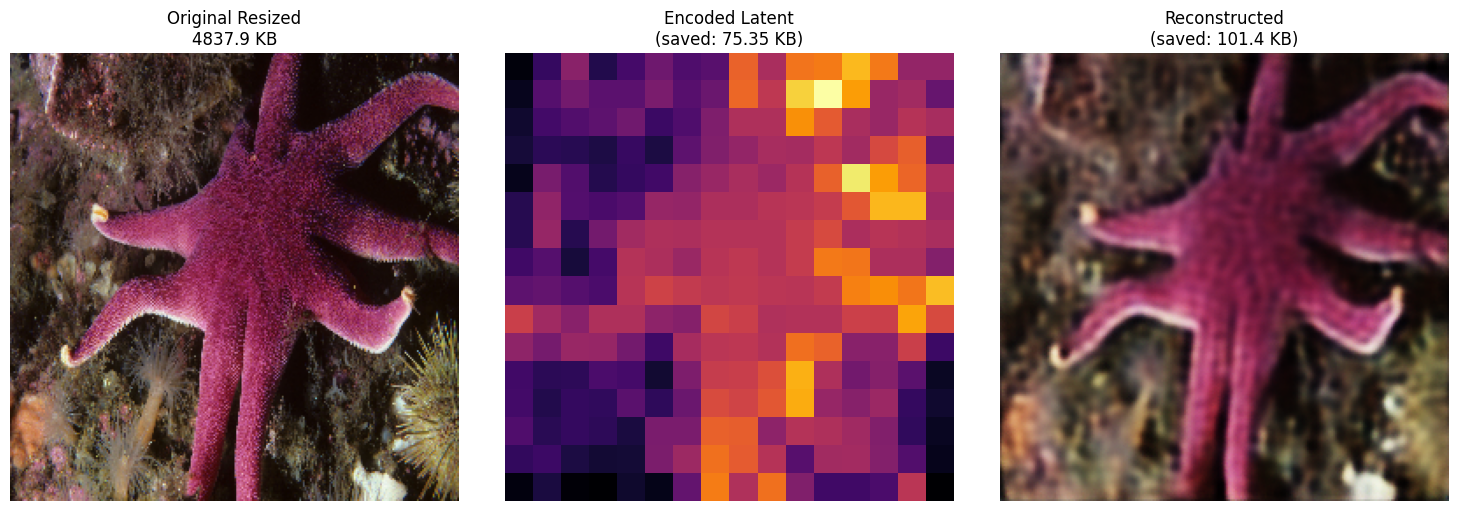


📁 Image: 0001.png
📦 Latent: C:/Users/rithi/Downloads/autoencoder/outputs/reconstructed\0001.npz (75.35 KB)
🖼️ Reconstructed: C:/Users/rithi/Downloads/autoencoder/outputs/reconstructed\0001_recon.png (101.4 KB)
📉 Compression ratio: 64.2× (orig → latent)
📊 Metrics →  PSNR: 22.06 dB  |  SSIM: 0.5144  |  Loss (MSE): 0.006227


In [8]:
img_path = r"C:\Users\rithi\Downloads\0001.png" 
if os.path.exists(img_path):
    latent_path, recon_path = process_image(img_path)
else:
    print("❌ Invalid image path:", img_path)
